In [1]:
import pandas as pd
import numpy as np
import talib as ta
import pendulum as pdl
import mplfinance as mpf

import sys
sys.path.append('../')
from sqlbase import engine, Base, db_session
from models import *
from stock_forecast import *
from tushare_tasks import *

# Constants
start_date = '2016-01-01'
end_date = '2020-02-20'

In [19]:
import pandas_profiling as pp

In [ ]:
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : f00ed8f47020034e752baf0250483053340971b0
python           : 3.8.2.final.0
python-bits      : 64
OS               : Darwin
OS-release       : 20.6.0
Version          : Darwin Kernel Version 20.6.0: Wed Jun 23 00:26:31 PDT 2021; root:xnu-7195.141.2~5/RELEASE_X86_64
machine          : x86_64
processor        : i386
byteorder        : little
LC_ALL           : None
LANG             : zh_CN.UTF-8
LOCALE           : None.UTF-8

pandas           : 1.3.0
numpy            : 1.21.0
pytz             : 2021.1
dateutil         : 2.8.1
pip              : 21.1.2
setuptools       : 57.0.0
Cython           : 0.29.23
pytest           : 6.2.4
hypothesis       : None
sphinx           : 4.0.2
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.6.3
html5lib         : 1.1
pymysql          : None
psycopg2         : 2.9.1 (dt dec pq3 ext lo64)
jinja2           : 3.0.1
IPython          : 7.26.0
pandas_datareader: 

In [2]:
def load_stock_price(ts_code, start_date=None, end_date=None):
    """
        从 pg db 获取股票数据
    """
    query_price = (
        db_session.query(Price)
            .filter(Price.ts_code == ts_code)
            .filter(Price.trade_date >= start_date)
            .filter(Price.trade_date <= end_date)
            .order_by(text('trade_date asc'))
    )
    price = pd.read_sql(query_price.statement, db_session.bind)
    price['trade_date'] = pd.to_datetime(price.trade_date)
    price.set_index('trade_date', inplace=True)
    
    query_adjfactor = (
        db_session.query(AdjFactor)
            .filter(AdjFactor.ts_code == ts_code)
            .filter(AdjFactor.trade_date >= start_date)
            .filter(AdjFactor.trade_date <= end_date)
    )
    adjfactor = pd.read_sql(query_adjfactor.statement, db_session.bind)
    adjfactor['trade_date'] = pd.to_datetime(adjfactor.trade_date)
    adjfactor.set_index('trade_date', inplace=True)
    df = price.join(adjfactor[['adj_factor']])
    return df
df = load_stock_price('000001.SZ', start_date=start_date, end_date=end_date)

In [3]:
# drop columns
df.drop(['index', 'id'], axis=1).head()

,open,id,ts_code,high,low,close,pre_close,change,pct_chg,vol,amount,adj_factor
trade_date,,,,,,,,,,,,
2016-01-04,12.00,1746436,000001.SZ,12.03,11.23,11.33,11.99,-0.66,-5.5000,563497.90,660376.10,85.994
2016-01-05,11.27,1751111,000001.SZ,11.57,11.15,11.40,11.33,0.07,0.6200,663269.94,755531.40,85.994
2016-01-06,11.42,1753234,000001.SZ,11.56,11.39,11.53,11.40,0.13,1.1400,515706.44,591698.50,85.994
2016-01-07,11.41,1754877,000001.SZ,11.41,10.91,10.94,11.53,-0.59,-5.1200,174761.10,194869.50,85.994
2016-01-08,11.21,1757911,000001.SZ,11.29,10.90,11.12,10.94,0.18,1.6500,747527.56,831334.56,85.994
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-14,14.75,3185982,000001.SZ,15.14,14.70,15.03,14.65,0.38,2.5939,1512434.80,2253906.50,109.169
2020-02-17,15.04,3188386,000001.SZ,15.37,14.93,15.37,15.03,0.34,2.2621,1543696.00,2337993.50,109.169
2020-02-18,15.33,3194083,000001.SZ,15.33,15.01,15.20,15.37,-0.17,-1.1061,973612.40,1478274.20,109.169


In [6]:
# datetime index slice
df.loc['2016-06':'2016-07']
df.last('1Y')

# multiindex
# 当第一个 index 为 datatime （timestamp）时，还是可以用下面方法
df.loc['2020-02-27']

# 多个 index slice：
# lvl0           a         b     
# lvl1         bar  foo  bah  foo
# A1 B0 C1 D0   73   72   75   74
#          D1   77   76   79   78
#       C3 D0   89   88   91   90
#          D1   93   92   95   94
#    B1 C1 D0  105  104  107  106
# ...          ...  ...  ...  ...
# A3 B0 C3 D1  221  220  223  222
#    B1 C1 D0  233  232  235  234
#          D1  237  236  239  238
#       C3 D0  249  248  251  250
#          D1  253  252  255  254
idx = pd.IndexSlice
dfmi.loc[idx[:, :, ['C1', 'C3']], idx[:, 'foo']]
dfs.loc['2020-02-27']

# 当第二个为datatime, 以下均不行
# df.loc['2018-03-02']
# df.loc[:,'2018-03-02']
# 这样可以：
df.loc['300737.SZ','2018-03-02']
df.loc['300737.SZ']['2019':'2020']
# 或者过滤
df.filter(like='2017-11-28', axis=0)
# 这个是最好的 （key 可以不存在）
df.xs(slice('2020-01-12','2020-01-15'), level=1, drop_level=False)

# 更换index 顺序
dfs = df.swaplevel()

# 其他参考：https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html

,open,id,ts_code,high,low,close,pre_close,change,pct_chg,vol,amount,adj_factor
trade_date,,,,,,,,,,,,
2016-01-04,12.00,1746436,000001.SZ,12.03,11.23,11.33,11.99,-0.66,-5.50,563497.90,660376.10,85.994
2016-01-05,11.27,1751111,000001.SZ,11.57,11.15,11.40,11.33,0.07,0.62,663269.94,755531.40,85.994
2016-01-06,11.42,1753234,000001.SZ,11.56,11.39,11.53,11.40,0.13,1.14,515706.44,591698.50,85.994
2016-01-07,11.41,1754877,000001.SZ,11.41,10.91,10.94,11.53,-0.59,-5.12,174761.10,194869.50,85.994
2016-01-08,11.21,1757911,000001.SZ,11.29,10.90,11.12,10.94,0.18,1.65,747527.56,831334.56,85.994
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-07-25,8.93,2094269,000001.SZ,8.98,8.91,8.98,8.94,0.04,0.45,264682.88,236937.50,104.758
2016-07-26,8.97,2096516,000001.SZ,9.12,8.97,9.11,8.98,0.13,1.45,546556.94,494506.40,104.758
2016-07-27,9.12,2098836,000001.SZ,9.17,8.91,9.01,9.11,-0.10,-1.10,818678.30,741263.30,104.758


In [11]:
# shift/roll
df['adj_pre_close'] = df.adj_close.shift(1)
df.loc['2016-06-13':'2016-06-20'].pct_chg.rolling(window=2).sum()
# 反向 roll
df.close.rolling(window=window).sum().shift(-window)
df['mavg5'] =df.groupby(level='ts_code').close.rolling(window=5).mean().values

,open,id,ts_code,high,low,close,pre_close,change,pct_chg,vol,amount,adj_factor
trade_date,,,,,,,,,,,,
2016-01-04,12.00,1746436,000001.SZ,12.03,11.23,11.33,11.99,-0.66,-5.50,563497.90,660376.10,85.994
2016-01-05,11.27,1751111,000001.SZ,11.57,11.15,11.40,11.33,0.07,0.62,663269.94,755531.40,85.994
2016-01-06,11.42,1753234,000001.SZ,11.56,11.39,11.53,11.40,0.13,1.14,515706.44,591698.50,85.994
2016-01-07,11.41,1754877,000001.SZ,11.41,10.91,10.94,11.53,-0.59,-5.12,174761.10,194869.50,85.994
2016-01-08,11.21,1757911,000001.SZ,11.29,10.90,11.12,10.94,0.18,1.65,747527.56,831334.56,85.994
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-07,10.52,2011828,000001.SZ,10.53,10.48,10.52,10.51,0.01,0.10,229282.16,240887.16,85.994
2016-06-08,10.54,2013912,000001.SZ,10.54,10.46,10.50,10.52,-0.02,-0.19,268188.25,281651.75,85.994
2016-06-13,10.46,2016347,000001.SZ,10.47,10.33,10.33,10.50,-0.17,-1.62,344816.84,358996.28,85.994


In [ ]:
# drop duplicate
df.drop_duplicates(subset=['ts_code', 'trade_date'], keep='first', inplace=False)

In [ ]:
# select by col name regex
df.select(lambda col: col.startswith('d'), axis=1)

In [ ]:
# series to frame
y = df.pct_chg.to_frame()

In [ ]:
# rolling on multindex
df['mavg5'] =df.groupby(level='ts_code').close.rolling(window=5).mean().values
# rolling sum 这样会多一个 index
df.groupby(level='ts_code').pct_chg.rolling(window=window).sum().shift(-window)
# rolling sum 必须这样
df.groupby(level='ts_code').pct_chg.apply(lambda x: x.rolling(window=3).sum().shift(-3))

In [ ]:
%%time
# read sql
db = pd.read_sql(db_session.query(DailyBasic).statement, db_session.bind)

# pandas read_sql is too slow
# ref: https://towardsdatascience.com/optimizing-pandas-read-sql-for-postgres-f31cd7f707ab
def read_sql_tmpfile(query, db_session):
    with tempfile.TemporaryFile() as tmpfile:
        copy_sql = "COPY ({query}) TO STDOUT WITH CSV {head}".format(
           query=query, head="HEADER"
        )
        conn = db_engine.raw_connection()
        cur = conn.cursor()
        cur.copy_expert(copy_sql, tmpfile)
        tmpfile.seek(0)
        df = pandas.read_csv(tmpfile)
        return df

In [ ]:
# format/style
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
# https://towardsdatascience.com/style-pandas-dataframe-like-a-master-6b02bf6468b0
df.head(10).style.format({"BasePay": "${:20,.0f}", 
                          "OtherPay": "${:20,.0f}", 
                          "TotalPay": "${:20,.0f}",
                          "TotalPayBenefits":"${:20,.0f}"})


In [ ]:
df.head(10).style.format({"BasePay": "${:20,.0f}", 
                          "OtherPay": "${:20,.0f}", 
                          "TotalPay": "${:20,.0f}",
                          "TotalPayBenefits":"${:20,.0f}"})\
                 .format({"JobTitle": lambda x:x.lower(),
                          "EmployeeName": lambda x:x.lower()})\
                 .hide_index()\
                .highlight_max(color='lightgreen')\                            
                .highlight_min(color='#cd4f39')

In [ ]:
# rank
df.loc[:,'rank'] = df.groupby(['trade_date','ts_code'])['net_buy'].rank(ascending=False, method='first').apply(lambda x: int(x))

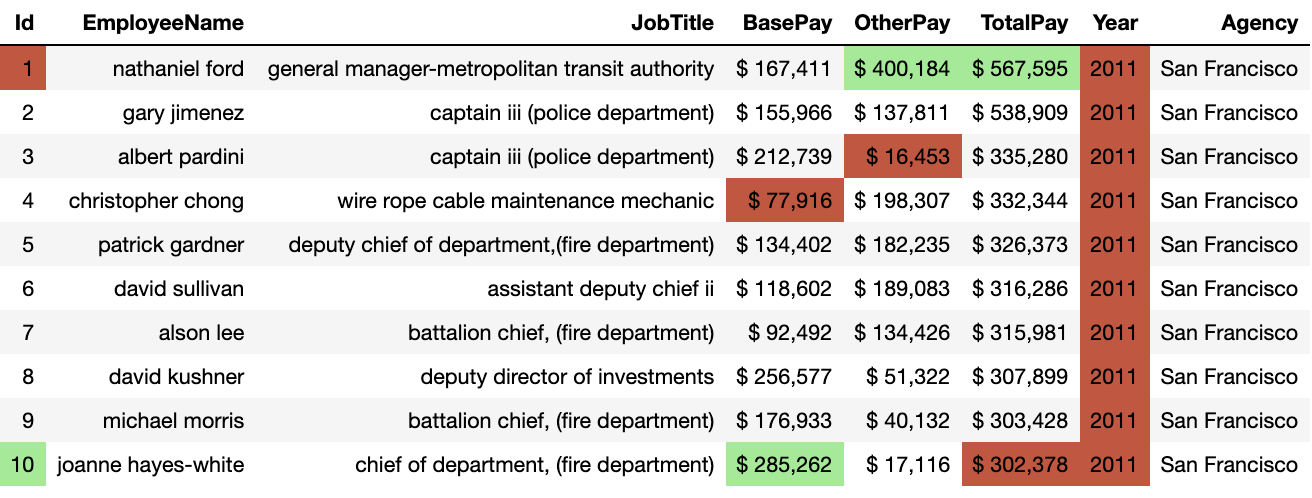

In [8]:
import numpy as np
np.around(23.94*0.9, 2)

21.55

In [6]:
26.86*1.1

29.546000000000003